In [1]:
"""
Example demonstrating the Robotics Toolbox adapter usage.

This example shows how to use the RTB adapter to:
1. Initialize the environment
2. Load/create robots and objects
3. Perform basic operations like forward kinematics, pose manipulation, etc.
"""

import numpy as np
import spatialmath as sm
import spatialgeometry as sg
from pandaSim.geometry.rtb_adapter import RoboticsToolboxAdapter
from pandaSim.planning.screw_motion_planner import ScrewMotionPlanner
from pandaSim.geometry.utils import convert_pose
from pandaSim.geometry.utils import create_virtual_panda
import trimesh
from pytransform3d import (
    transformations as pt,
    rotations as pr,
    batch_rotations as pb,
    trajectories as ptr,
    plot_utils as ppu
)
import qpsolvers as qp


# auto reload
%load_ext autoreload
%autoreload 2

[I 09/23/25 14:21:25.525 18741] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [ ]:
panda_path = '../model/franka_description/robots/frankaEmikaPandaVirtual.urdf'
panda_sim = create_virtual_panda(urdf_path=panda_path)

In [37]:
# Create simulation environment
adapter = RoboticsToolboxAdapter({
    "realtime": True,
    "rate": 100,
    "browser": "google-chrome"  # or "notebook" for visualizing in jupyter notebook
})

# Create virtual robot
urdf_path = '../model/franka_description/robots/frankaEmikaPandaVirtual.urdf'
panda_sim = create_virtual_panda(urdf_path=urdf_path)
panda_sim.base = sm.SE3(0, 0, 0.013)
n = 7  # arm DOF

# Sync simulation with real robot
# panda_sim.q[:n] = panda_real.q[:n]

# Add robot to environment
env = adapter.env
env.add(panda_sim)

# Open gripper
if hasattr(panda_sim, 'grippers') and panda_sim.grippers:
    panda_sim.grippers[0].q = [0.035, 0.035]

print(f"Simulation setup complete. Rate: {adapter.env.rate} Hz")

# Create scene objects
box_size = [0.27, 0.065, 0.207]
box = sg.Box(
    scale=box_size, 
    color='blue', 
    pose=sm.SE3(0.5, 0.0, box_size[2]/2)
)
robot_desk = sg.Box(
    scale=[0.3, 0.3, 0.013], 
    color='gray', 
    pose=sm.SE3(-0.04, 0, 0.013/2),
)
robot_desk.set_alpha(0.5)
# Visualization axes
ee_axes = sg.Axes(0.15)  # End-effector pose
goal_axes = sg.Axes(0.1)  # Target grasp pose

# Add to environment
env.add(ee_axes)
env.add(goal_axes)
env.add(box)
env.add(robot_desk)
# Update end-effector visualization
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')

# Compute grasp pose
planner = ScrewMotionPlanner(adapter=adapter)

grasp_pose, qs, s_axes = planner.compute_grasp(
    obj=box,
    adapter=adapter,
    grasp_height="top",
    prefer_closer_grasp=True,
    gripper_offset=sm.SE3.Rx(np.pi/2).A,
    output_type="t"
)

# Update goal visualization
goal_axes.T = grasp_pose

# For object manipulation: compute relative transform
wTg = grasp_pose  # grasp pose in world
wTb = box.T       # box pose in world
gTb = np.linalg.inv(wTg) @ wTb  # box pose in grasp 
adapter.step_simulation(adapter.dt)

print(f"Grasp pose computed. Distance to target: {np.linalg.norm(grasp_pose[:3, 3] - panda_sim.fkine(panda_sim.q).t):.3f}m")


Simulation setup complete. Rate: 100 Hz
Grasp pose computed. Distance to target: 0.350m


In [38]:
# Direct instantiation
from pandaSim.control import QPController

controller = QPController(adapter=adapter, 
                          robot=panda_sim,
                          end_effector_link='panda_finger_virtual', 
                          gains_translation=2.0, 
                          gains_rotation=2.0, 
                          threshold=0.001, 
                          lambda_q=0.05, 
                          lambda_m=1.0, 
                          lambda_j=0.1,
                          ps=0.5, 
                          pi=0.3, 
                          eta=1.0, 
                          solver='quadprog',
                          T=2)



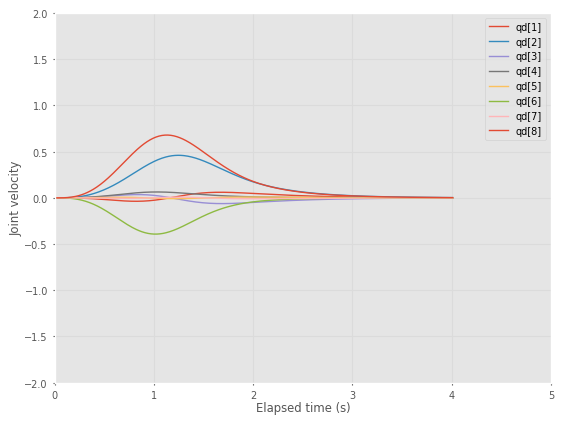

In [39]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

panda_sim.q = panda_sim.qr
arrived = False

qd_history = []
q_history = []
manipulability_measure = []
time_history = []

dt = 1/env.rate
elapsed_time = 0.0

fig, ax = plt.subplots()
lines = [ax.plot([], [], label=f'qd[{i+1}]', linewidth=1)[0] for i in range(panda_sim.n)]
ax.set_xlim(0, 20) 
ax.set_ylim(-2, 2)   
ax.set_xlabel('Elapsed time (s)')
ax.set_ylabel('Joint velocity')
ax.legend()
plt.ion()
plt.show()

step = 0
while not arrived:
    qd, arrived = controller.compute_joint_velocities(grasp_pose, optimization_type="j")
    goal_axes.T = grasp_pose
    qd = controller.smooth_velocity_ramp(qd_cmd=qd, elapsed_time=elapsed_time, method="quintic")
    adapter.control_joint_velocities(panda_sim, qd)
    ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
    adapter.step_simulation(dt)
    qd_history.append(qd[:panda_sim.n].copy())
    q_history.append(panda_sim.q[:panda_sim.n].copy())
    elapsed_time += dt
    time_history.append(elapsed_time)
    if step % 10 == 0:  # update plot every 0.1 seconds for speed
        clear_output(wait=True)
        for i, line in enumerate(lines):
            line.set_data(time_history, [q[i] for q in qd_history])
        ax.set_xlim(0, max(5, elapsed_time))
        display(fig)
    step += 1

q_arrived = panda_sim.q.copy()

plt.ioff()
plt.show()


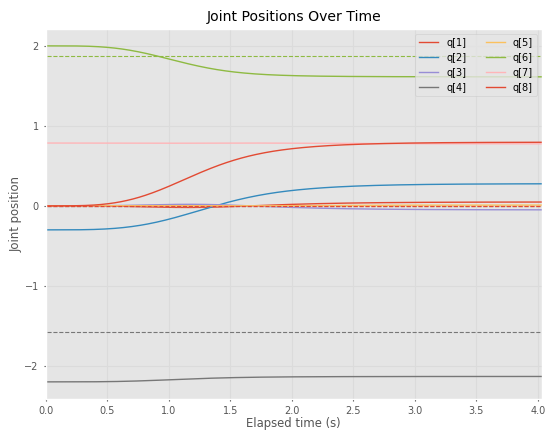

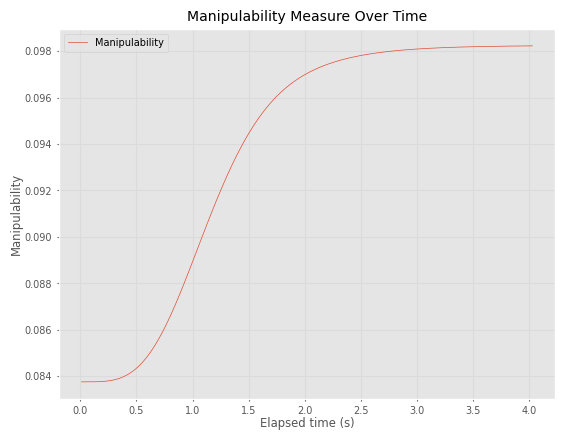

In [40]:
import matplotlib.pyplot as plt

q_history = np.array(q_history)
time_history = np.array(time_history)
manipulability_measure = panda_sim.manipulability(q=q_history)
# Get joint limits
q_min, q_max = adapter.get_joint_limits(panda_sim)

fig2, ax2 = plt.subplots()

lines = []
for i in range(q_history.shape[1]):
    # Plot joint position
    line, = ax2.plot(time_history, q_history[:, i], label=f'q[{i+1}]', linewidth=1)
    lines.append(line)
    color = line.get_color()
    # Plot middle joint limit as dashed line with same color
    q_mid = (q_min[i] + q_max[i]) / 2
    ax2.hlines(q_mid, time_history[0], time_history[-1], colors=color, linestyles='dashed', linewidth=0.8)

ax2.set_xlim(0, max(time_history))
ax2.set_xlabel('Elapsed time (s)')
ax2.set_ylabel('Joint position')
ax2.set_title('Joint Positions Over Time')
ax2.legend(loc='upper right', ncol=2)
plt.show()


# Plot manipulability measure history over time
fig3, ax3 = plt.subplots()
ax3.plot(time_history, manipulability_measure, label='Manipulability')
ax3.set_xlabel('Elapsed time (s)')
ax3.set_ylabel('Manipulability')
ax3.set_title('Manipulability Measure Over Time')
ax3.legend()
plt.show()


In [51]:
task_time = 10.0



twist_b = planner.generate_twist_trajectory(body_pose=grasp_pose,
                                            q=qs, 
                                            s_axis=s_axes, 
                                            theta=np.pi/2, 
                                            h=0.0, 
                                            Tf=task_time, 
                                            time_scaling='quintic', 
                                            body_coordinate=True)


# twist_dq_b = planner.generate_twist_trajectory_dq(body_pose=grasp_pose,
#                                             q=qs, 
#                                             s_axis=s_axes, 
#                                             theta=np.pi/2, 
#                                             h=0.0, 
#                                             theta_dot=0.1,
#                                             Tf=task_time, 
#                                             time_scaling='quintic', 
#                                             body_coordinate=True)

# twist_dq_b


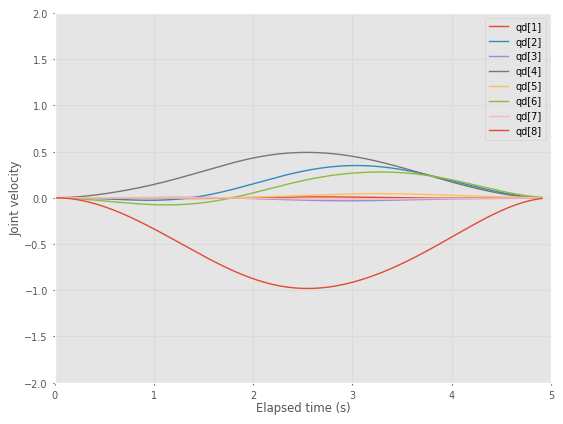

In [50]:

panda_sim.q = q_arrived
arrived = False

qd_history = []
q_history = []
time_history = []

elapsed_time = 0.0

fig, ax = plt.subplots()

lines = [ax.plot([], [], label=f'qd[{i+1}]', linewidth=1)[0] for i in range(panda_sim.n)]
ax.set_xlim(0, 20) 
ax.set_ylim(-2, 2)   
ax.set_xlabel('Elapsed time (s)')
ax.set_ylabel('Joint velocity')
ax.legend()
plt.ion()
plt.show()

step = 0
for twist in twist_b:
        # while not arrived:
        qd, arrived = controller.compute_joint_velocities(twist=twist, optimization_type="joint_limit")
        goal_axes.T = grasp_pose
        # qd = controller.smooth_velocity_ramp(qd_cmd=qd, elapsed_time=elapsed_time, method="quintic")
        adapter.control_joint_velocities(panda_sim, qd)
        wTe = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
        ee_axes.T = wTe
        box.T = wTe * gTb #SE3
        adapter.step_simulation(dt)
        qd_history.append(qd[:panda_sim.n].copy())
        q_history.append(panda_sim.q[:panda_sim.n].copy())
        elapsed_time += dt
        time_history.append(elapsed_time)
        if step % 10 == 0:  # update plot every 0.1 seconds for speed
            clear_output(wait=True)
            for i, line in enumerate(lines):
                line.set_data(time_history, [q[i] for q in qd_history])
            ax.set_xlim(0, max(5, elapsed_time))
            display(fig)
        step += 1



plt.ioff()
plt.show()

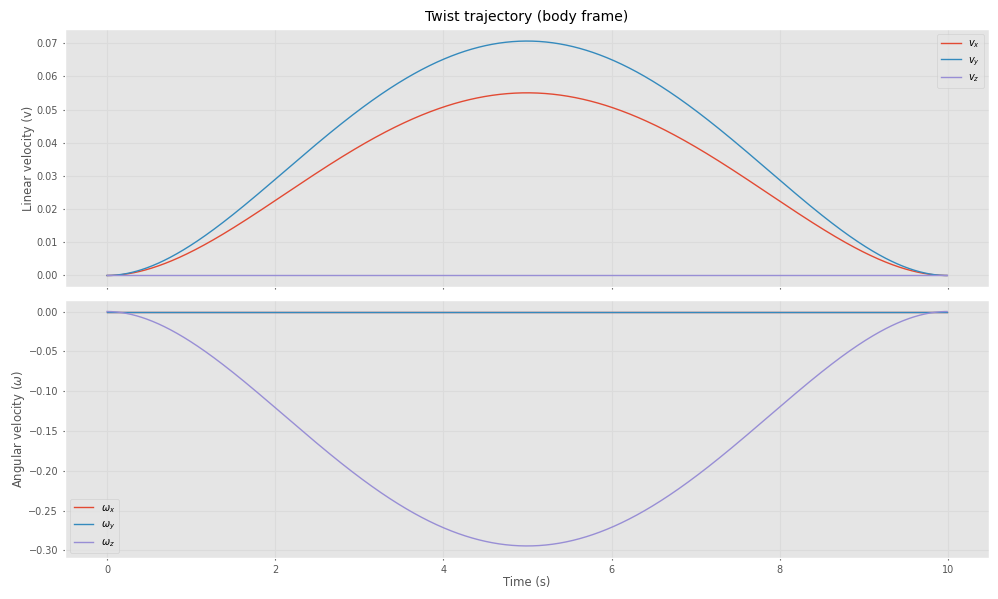

In [43]:

# Plot twist_b: (v, omega) order, shape (N, 6)
time_twist = np.arange(len(twist_b)) * dt
labels = [r'$v_x$', r'$v_y$', r'$v_z$', r'$\omega_x$', r'$\omega_y$', r'$\omega_z$']
ylabels = ['Linear velocity (v)', 'Angular velocity ($\omega$)']

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
for i in range(3):
    axes[0].plot(time_twist, twist_b[:, i], label=labels[i], linewidth=1)
    axes[1].plot(time_twist, twist_b[:, i+3], label=labels[i+3], linewidth=1)

for ax, ylabel in zip(axes, ylabels):
    ax.set_ylabel(ylabel)
    ax.legend()
axes[1].set_xlabel('Time (s)')
axes[0].set_title('Twist trajectory (body frame)')
plt.tight_layout()
plt.show()


In [46]:
sm.SE3(box.T)

   0.001795 -0.0001002  1         0.7382    
  -8.072e-05  1         0.0001004  1.728e-05  
  -1        -8.09e-05  0.001795  0.1364    
   0         0         0         1         
